# HW4 - Evaluation measures and logistic regression

## Task 1: Evaluation measures (2 points)

This task is built around the banknote authentication dataset. These data were extracted from images that were taken for the evaluation of an authentication procedure for banknotes. Original dataset has 5 features but we have decided to keep only 2, in order to make the classification task harder. There are two classes in this task: forged (1) and genuine (0). See more details about the data at https://archive.ics.uci.edu/ml/datasets/banknote+authentication .

In [1]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, \
                            f1_score, roc_curve, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from IPython.display import display

In [2]:
df = pd.read_csv('data_banknote_authentication.txt', header = None, names=['variance','skewness','curtosis','entropy','y'])
df = df.drop(columns=['skewness','variance']) # We'll remove these two columns to make the task harder
pd.set_option('max_rows', 10)
display(df)

,curtosis,entropy,y
0,-2.8073,-0.44699,0
1,-2.4586,-1.46210,0
2,1.9242,0.10645,0
3,-4.0112,-3.59440,0
4,4.5718,-0.98880,0
...,...,...,...
1367,-1.4501,-0.55949,1
1368,6.4774,0.34179,1
1369,17.5932,-2.77710,1
1370,12.3930,-1.28230,1


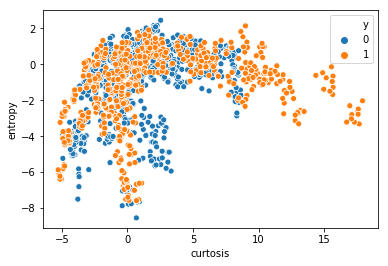

In [3]:
sns.scatterplot(df['curtosis'],df['entropy'],hue=df['y'])
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('y', axis=1), df.y, 
                                                    train_size=0.7, test_size=0.3, 
                                                    random_state=0, shuffle=True, stratify=df.y)
X_train.shape, X_test.shape

((960, 2), (412, 2))

Now we will train and evaluate several classifiers. We will tune them as well in order to find optimal parameters and achieve  the best possible performance.

Every `sklearn` classifier has a set of tuneable parameters, you can check the list of defaults parameters like that:

In [5]:
knn = KNeighborsClassifier()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': 1,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

For the parameter tuning you can use Grid Search (check every possible combination of parameters from the predefined dictionary). Let us see what parameter values it found as best:

In [6]:
knn_param_grid = {
    'weights':['uniform', 'distance'],
    'n_neighbors': [1, 3, 5, 10, 15, 20, 30, 100]
}

knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=3, return_train_score=True)
knn_grid_search.fit(X_train, y_train)
knn_grid_search.best_params_

{'n_neighbors': 1, 'weights': 'uniform'}

- **(a)** On the test set calculate the accuracy of the KNN model with default parameters and with the parameters selected by cross-validation. Which is better and why?

In [7]:
knn_default = KNeighborsClassifier()
knn_default.fit(X_train, y_train)
knn_default_predictions = knn_default.predict(X_test)

knn_grid_search_predictions = knn_grid_search.predict(X_test)

knn_default_test_accuracy = accuracy_score(knn_default_predictions, y_test)
knn_tuned_test_accuracy = accuracy_score(knn_grid_search_predictions, y_test)

print('KNN test accuracy with default parameters:',knn_default_test_accuracy)
print('KNN test accuracy after parameter tuning :',knn_tuned_test_accuracy)

KNN test accuracy with default parameters: 0.7257281553398058
KNN test accuracy after parameter tuning : 0.6820388349514563


**<font color='purple'>Answer to (a):</font>** The default parameters are better. Probably since we didnt try out enough parameters for the grid search and we got best of the ones provided, but still bad parameters.

- **(b)** Look at the detailed results of cross-validation as printed below. The columns ending with '_time' are about running time, but please describe the meaning of other columns.

In [8]:
knn_cv_results = pd.DataFrame(knn_grid_search.cv_results_)
knn_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.002992,0.001629,0.000998,3.893359e-07,1,uniform,"{'n_neighbors': 1, 'weights': 'uniform'}",0.704050,0.731250,0.699060,0.711458,0.014142,1,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.001330,0.000470,0.001329,4.696846e-04,1,distance,"{'n_neighbors': 1, 'weights': 'distance'}",0.704050,0.731250,0.699060,0.711458,0.014142,1,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.001662,0.000472,0.001995,8.141996e-04,3,uniform,"{'n_neighbors': 3, 'weights': 'uniform'}",0.704050,0.681250,0.699060,0.694792,0.009790,8,0.866980,0.853125,0.861154,0.860420,0.005680
3,0.002327,0.001245,0.001994,8.144911e-04,3,distance,"{'n_neighbors': 3, 'weights': 'distance'}",0.669782,0.684375,0.705329,0.686458,0.014587,12,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.001330,0.000470,0.000997,1.123916e-07,5,uniform,"{'n_neighbors': 5, 'weights': 'uniform'}",0.685358,0.653125,0.686520,0.675000,0.015475,14,0.813772,0.796875,0.811232,0.807293,0.007439


**<font color='purple'>Answer to (b):</font>**  
param_* and params contain all the parameters that were used for this testing. We can see that the first values are 1 for "n_neighbors" and "uniform" for "weights".  
split*_test_score shows the testing score, when the model was fitted with the *-th split. Mean and std are also included.
rank_test_score contains the ranking of the current parameters on the test data.  
split*_train_score shows the training score, when the model was fitted iwth the *-th split. Mean and std are also included

<font color='red'>Note that the column names involving the word 'test' might be a bit confusing - they are referring to the test fold within cross-validation, which perhaps could be better called a validation fold. Therefore, the accuracies in this table are also potentially different from what you found in subtask (b).</font>

Let us now keep only some of the columns which are the most relevant for our purpose. Also, let us sort the results by mean_test_score.

In [9]:
def cv_column_filter(df):
    return(df.loc[:,[c for c in df.columns 
                     if (c[:11]=='mean_train_') or 
                        (c[:10]=='mean_test_') or 
                        (c[:6]=='param_')]])

knn_cv_results = cv_column_filter(knn_cv_results)
knn_cv_results = knn_cv_results.sort_values('mean_test_score',ascending=False)
pd.set_option('max_rows', 20)
knn_cv_results

,param_n_neighbors,param_weights,mean_test_score,mean_train_score
0,1,uniform,0.711458,1.000000
1,1,distance,0.711458,1.000000
11,20,distance,0.709375,1.000000
7,10,distance,0.704167,1.000000
9,15,distance,0.703125,1.000000
13,30,distance,0.703125,1.000000
15,100,distance,0.703125,1.000000
2,3,uniform,0.694792,0.860420
5,5,distance,0.688542,1.000000
6,10,uniform,0.688542,0.764061


- **(c)** Looking at the above table, are both parameters important factors for the performance of KNN? Generally, is more or less neighbours good in this task? Is uniform or distance-based weighting better in this task?

**<font color='purple'>Answer to (c):</font>** We can see that both parameters are important for the performance. It is generally good to have less neighbours and use distance-based weighting.

- **(d)** Let us now wrap up parameter tuning process into a single function, which would later work for other types of models as well, not just KNN models. Compare the displayed table to knn_cv_results above and explain the meaning of extra columns.

In [10]:
def tune_model(model, param_grid, X_train=X_train, y_train=y_train, cv=5, max_rows=10):
    grid_search = GridSearchCV(model, param_grid, cv=cv, return_train_score=True, scoring=['accuracy','f1','roc_auc'],refit='accuracy')
    grid_search.fit(X_train, y_train)
    cv_results = pd.DataFrame(grid_search.cv_results_)
    cv_results = cv_column_filter(cv_results)
    cv_results = cv_results.sort_values('mean_test_accuracy',ascending=False)
    pd.set_option('max_rows',max_rows)
    display(cv_results)
    pd.reset_option('max_rows')
    return(grid_search)

In [11]:
knn = KNeighborsClassifier()
knn_param_grid = {
    'weights':['uniform', 'distance'],
    'n_neighbors': [1, 3, 5, 10, 15, 20, 30, 100]
}
knn_tuned = tune_model(knn,knn_param_grid,cv=3,max_rows=20)
print(knn_tuned.best_params_)
print(knn_tuned.best_score_)

,param_n_neighbors,param_weights,mean_test_accuracy,mean_train_accuracy,mean_test_f1,mean_train_f1,mean_test_roc_auc,mean_train_roc_auc
0,1,uniform,0.711458,1.000000,0.678228,1.000000,0.708682,1.000000
1,1,distance,0.711458,1.000000,0.678228,1.000000,0.708682,1.000000
11,20,distance,0.709375,1.000000,0.647773,1.000000,0.776864,1.000000
7,10,distance,0.704167,1.000000,0.651873,1.000000,0.784004,1.000000
9,15,distance,0.703125,1.000000,0.644133,1.000000,0.778085,1.000000
13,30,distance,0.703125,1.000000,0.625021,1.000000,0.775788,1.000000
15,100,distance,0.703125,1.000000,0.583758,1.000000,0.757162,1.000000
2,3,uniform,0.694792,0.860420,0.646387,0.841092,0.741453,0.933636
5,5,distance,0.688542,1.000000,0.639328,1.000000,0.775684,1.000000
6,10,uniform,0.688542,0.764061,0.590884,0.693509,0.751756,0.844851


{'n_neighbors': 1, 'weights': 'uniform'}
0.7114583333333333


**<font color='purple'>Answer to (d):</font>** We have two extra evaluation measures on both train set and test sets. The F1 and ROC measures.

- **(e)** Are different parameter settings ranked similarly according to different evaluation measures? What are the similarities and differences between measures, according to which parameter settings they consider better or worse?

**<font color='purple'>Answer to (e):</font>** F1 acts more similar to the accuracy, but ROC seems to act a bit different. While accuracy is a single evaluation measure, F1 is influenced by precision and accuracy. ROC is influenced by the TPR and FPR.

- **(f)** Tune the Decision Tree learner by trying out 20-100 different combinations of at least 2 parameters. Report the best hyperparameter values and the cross-validated accuracy estimate. Hint: see how the same was done above using knn_tuned object.

In [12]:
dt = DecisionTreeClassifier()
dt_grid = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "min_samples_split": [2, 3, 5, 7, 10, 12, 15, 17],
    "max_features": ["auto", "log2"]
}
dt_tuned = tune_model(dt, dt_grid)
print('Best hyperparameter values:', dt_tuned.best_params_)
print('Cross-validated accuracy estimate for these parameter values:',dt_tuned.best_score_)

,param_criterion,param_max_features,param_min_samples_split,param_splitter,mean_test_accuracy,mean_train_accuracy,mean_test_f1,mean_train_f1,mean_test_roc_auc,mean_train_roc_auc
62,entropy,log2,17,best,0.684375,0.846095,0.631947,0.821471,0.711450,0.935516
12,gini,auto,15,best,0.682292,0.848702,0.620485,0.821613,0.717996,0.936498
4,gini,auto,5,best,0.679167,0.934371,0.617112,0.923772,0.691149,0.989548
3,gini,auto,3,random,0.676042,0.889852,0.585405,0.858576,0.677882,0.975322
51,entropy,log2,3,random,0.676042,0.887771,0.592273,0.855464,0.682775,0.974323
...,...,...,...,...,...,...,...,...,...,...
0,gini,auto,2,best,0.634375,1.000000,0.586480,1.000000,0.629289,1.000000
47,entropy,auto,17,random,0.628125,0.708847,0.512256,0.627567,0.649464,0.786977
27,gini,log2,12,random,0.628125,0.747406,0.520173,0.680490,0.672120,0.837754
1,gini,auto,2,random,0.627083,1.000000,0.574090,1.000000,0.621359,1.000000


Best hyperparameter values: {'criterion': 'entropy', 'max_features': 'log2', 'min_samples_split': 17, 'splitter': 'best'}
Cross-validated accuracy estimate for these parameter values: 0.684375


- **(g)** Tune the Random Forest learner by trying out 20-100 different combinations of at least 2 parameters. Report the best hyperparameter values and the cross-validated accuracy estimate. Compare columns of mean_train_accuracy and mean_test_accuracy and report which parameter values lead to more overfitting or less overfitting (or whether there is any overfitting at all).

In [13]:
rf = RandomForestClassifier()
rf_grid = {
    "n_estimators": [5,10,15,20],
    "criterion": ["gini", "entropy"],
    "min_samples_split": [2, 3, 5, 7, 10],
    "max_features": ["auto", "log2"]
}
rf_tuned = tune_model(rf, rf_grid)
print('Best hyperparameter values:',rf_tuned.best_params_)
print('Cross-validated accuracy estimate for these parameter values:',rf_tuned.best_score_)

,param_criterion,param_max_features,param_min_samples_split,param_n_estimators,mean_test_accuracy,mean_train_accuracy,mean_test_f1,mean_train_f1,mean_test_roc_auc,mean_train_roc_auc
9,gini,auto,5,10,0.702083,0.951035,0.645819,0.944247,0.754327,0.990723
55,entropy,auto,7,20,0.700000,0.948440,0.642595,0.940895,0.757577,0.992551
18,gini,auto,10,15,0.698958,0.909638,0.641477,0.895064,0.760896,0.976115
77,entropy,log2,10,10,0.698958,0.908854,0.637989,0.893981,0.760837,0.974759
30,gini,log2,5,15,0.697917,0.958332,0.644018,0.952388,0.757134,0.993723
...,...,...,...,...,...,...,...,...,...,...
5,gini,auto,3,10,0.668750,0.969004,0.608564,0.964700,0.740850,0.996787
56,entropy,auto,10,5,0.667708,0.875010,0.618348,0.855416,0.734809,0.953163
0,gini,auto,2,5,0.667708,0.957288,0.618568,0.951702,0.713981,0.990119
36,gini,log2,10,5,0.660417,0.871092,0.607028,0.850209,0.726286,0.950196


Best hyperparameter values: {'criterion': 'gini', 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 10}
Cross-validated accuracy estimate for these parameter values: 0.7020833333333333


**<font color='purple'>Answer to (g):</font>** It would seem like selecting the amount of max features automatically tends to lead to more overfitting. Having les samples to split by also tends to lead to more overfitting.

- **(h)** Tune the SVM-RBF learner by trying out 20-100 different combinations of at least 2 parameters. Report the best hyperparameter values and the cross-validated accuracy estimate. 

In [14]:
pd.set_option('max_rows', 10)
svm = SVC(kernel='rbf', probability=True)
svm_grid = {
    "C": [1, 2.5, 5, 10, 25],
    "gamma": [1, 2.5, 5, 10, 25],
    "decision_function_shape": ["ovo", "ovr"]
}
svm_tuned = tune_model(svm, svm_grid)
print('Best hyperparameter values:',svm_tuned.best_params_)
print('Cross-validated accuracy estimate for these parameter values:', svm_tuned.best_score_)

,param_C,param_decision_function_shape,param_gamma,mean_test_accuracy,mean_train_accuracy,mean_test_f1,mean_train_f1,mean_test_roc_auc,mean_train_roc_auc
26,5,ovr,2.5,0.742708,0.842712,0.695031,0.810872,0.783003,0.910663
21,5,ovo,2.5,0.742708,0.842712,0.695031,0.810872,0.783003,0.910663
2,1,ovo,5,0.741667,0.844792,0.687221,0.812047,0.782693,0.917843
7,1,ovr,5,0.741667,0.844792,0.687221,0.812047,0.782693,0.917843
1,1,ovo,2.5,0.738542,0.814065,0.676347,0.773545,0.782852,0.884779
...,...,...,...,...,...,...,...,...,...
29,5,ovr,25,0.675000,0.960679,0.615737,0.955267,0.691414,0.990227
39,10,ovr,25,0.670833,0.973696,0.613631,0.970174,0.679749,0.993670
34,10,ovo,25,0.670833,0.973696,0.613631,0.970174,0.679749,0.993670
44,25,ovo,25,0.668750,0.982553,0.614067,0.980221,0.671433,0.996805


Best hyperparameter values: {'C': 5, 'decision_function_shape': 'ovo', 'gamma': 2.5}
Cross-validated accuracy estimate for these parameter values: 0.7427083333333333


- **(i)** All the above models can produce class probabities. For example, with the decision tree the probabilities for the first 5 training instances are as follows. What would the predicted classes on these 5 instances be, if we thresholded the model at probability 0.5?

In [15]:
pd.DataFrame(dt_tuned.predict_proba(X_train)[:5,:],columns=dt_tuned.classes_)

,0,1
0,0.0,1.0
1,0.0,1.0
2,0.5,0.5
3,0.0,1.0
4,1.0,0.0


**<font color='purple'>Answer to (i):</font>** If the threshold would be at $0.5$ then the first, second and fourth instances would get classified as positive and the other oens as negative.

- **(j)** Next we define a new class ThresholdedModel which can be constructed from any classifier which can produce class probabilities using predict_proba function. Construct a ThresholdedModel on rf_tuned with threshold 0.5. Report what the predicted classes are for the first 5 training instances. Also report the overall accuracy and F1-measure on the training set.

In [16]:
class ThresholdedModel:
    def __init__(self,model,threshold):
        self.model = model
        self.threshold = threshold
    def __str__(self):
        return('%s thresholded at %f' % (str(self.model.estimator).split('(')[0],self.threshold))
    def predict(self,X):
        return(np.array(self.model.predict_proba(X)[:,1] >= self.threshold, dtype=int))

In [17]:
rf_thr05 = ThresholdedModel(rf_tuned, 0.5)
rf_thr05_predictions = rf_thr05.predict(X_train[:5])
print('Predicted classes of first 5 instances are:',rf_thr05_predictions)
print('Training set accuracy:',accuracy_score(rf_thr05_predictions, y_train[:5]))
print('Training set F-measure:',f1_score(y_train[:5], rf_thr05_predictions))

Predicted classes of first 5 instances are: [1 1 0 1 0]
Training set accuracy: 1.0
Training set F-measure: 1.0


- **(k)** Next we define a function to consider all possible thresholds and find the one which maximizes the F-measure on the training data. Please explain what each of the 4 rows is doing in the function.

In [18]:
def optimize_threshold(model, measure_func, X, y):
    predictions = model.predict_proba(X)[:,1]    ### ROW 1
    thresholds = sorted(np.unique(list(predictions)+[np.inf]))     ### ROW 2
    scores = [measure_func(y,np.array(predictions>=t, dtype=int)) for t in thresholds]    ### ROW 3
    return(ThresholdedModel(model,thresholds[np.argmax(scores)]))   ### ROW 4

dt_opt_f1 = optimize_threshold(dt_tuned,f1_score,X_train,y_train)
dt_opt_acc = optimize_threshold(dt_tuned,accuracy_score,X_train,y_train)
rf_opt_f1 = optimize_threshold(rf_tuned,f1_score,X_train,y_train)
rf_opt_acc = optimize_threshold(rf_tuned,accuracy_score,X_train,y_train)
svm_opt_f1 = optimize_threshold(svm_tuned,f1_score,X_train,y_train)
svm_opt_acc = optimize_threshold(svm_tuned,accuracy_score,X_train,y_train)
print(dt_opt_f1)
print(dt_opt_acc)
print(rf_opt_f1)
print(rf_opt_acc)
print(svm_opt_f1)
print(svm_opt_acc)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


DecisionTreeClassifier thresholded at 0.428571
DecisionTreeClassifier thresholded at 0.500000
RandomForestClassifier thresholded at 0.441667
RandomForestClassifier thresholded at 0.441667
SVC thresholded at 0.405142
SVC thresholded at 0.455394


**<font color='purple'>Answer to (k):</font>** The first row saves the predictions. Second row saves all the possible ordered predictions and adds infinity as one of them. Third row calculates all of the scores for each of the thresholds. The fourth row returns the model with the best threshold.

- **(l)** Run the code below to evaluate the constructed models with several measures. Judging by accuracy, which of the models are less affected by overfitting, which more affected?

In [19]:
from sklearn.metrics import SCORERS,make_scorer

def evaluate_models(models,measures,X,y):
    return(pd.concat( [pd.DataFrame({'model':[str(model) for model in models]}),
        pd.DataFrame({measure:[SCORERS[measure](model,X,y) for model in models] for measure in measures}) ],axis=1))

models = [dt_tuned,dt_opt_acc,dt_opt_f1,
          rf_tuned,rf_opt_acc,rf_opt_f1,
          svm_tuned,svm_opt_acc,svm_opt_f1]
measures = ['accuracy','precision','recall','f1']
display(evaluate_models(models,measures,X_train,y_train))
display(evaluate_models(models,measures,X_test,y_test))

,model,accuracy,precision,recall,f1
0,"GridSearchCV(cv=5, error_score='raise',\n ...",0.865625,0.888021,0.798595,0.840937
1,DecisionTreeClassifier thresholded at 0.500000,0.865625,0.853081,0.843091,0.848057
2,DecisionTreeClassifier thresholded at 0.428571,0.861458,0.826667,0.871194,0.848347
3,"GridSearchCV(cv=5, error_score='raise',\n ...",0.947917,0.945626,0.936768,0.941176
4,RandomForestClassifier thresholded at 0.441667,0.953125,0.922566,0.976581,0.948805
5,RandomForestClassifier thresholded at 0.441667,0.953125,0.922566,0.976581,0.948805
6,"GridSearchCV(cv=5, error_score='raise',\n ...",0.833333,0.857909,0.749415,0.800000
7,SVC thresholded at 0.455394,0.838542,0.850515,0.772834,0.809816
8,SVC thresholded at 0.405142,0.837500,0.828087,0.800937,0.814286


,model,accuracy,precision,recall,f1
0,"GridSearchCV(cv=5, error_score='raise',\n ...",0.716019,0.701220,0.628415,0.662824
1,DecisionTreeClassifier thresholded at 0.500000,0.723301,0.686486,0.693989,0.690217
2,DecisionTreeClassifier thresholded at 0.428571,0.720874,0.670000,0.732240,0.699739
3,"GridSearchCV(cv=5, error_score='raise',\n ...",0.686893,0.639175,0.677596,0.657825
4,RandomForestClassifier thresholded at 0.441667,0.691748,0.629630,0.743169,0.681704
5,RandomForestClassifier thresholded at 0.441667,0.691748,0.629630,0.743169,0.681704
6,"GridSearchCV(cv=5, error_score='raise',\n ...",0.740291,0.731707,0.655738,0.691643
7,SVC thresholded at 0.455394,0.730583,0.706897,0.672131,0.689076
8,SVC thresholded at 0.405142,0.725728,0.688172,0.699454,0.693767


**<font color='purple'>Answer to (l):</font>** Looking at the train and test accuracy we see that the ones in the front suffer the most under overfitting. The latter ones have less overfitting and their general accuracy is better.

- **(m)** From the above tables compare the F-measure performance of the cross-validated model using default threshold (*_tuned) with the threshold specifically optimised for F-measure. Was there any benefit from threshold optimisation?

**<font color='purple'>Answer to (m):</font>** We can see that generally the models that were optimized for the F-measure had a better score on the F-measure. It would be safe to say that thhere was some benefit to it.

- **(n)** From the above tables compare the accuracy performance of the cross-validated model using default threshold (*_tuned) with the threshold specifically optimised for accuracy. Was there any benefit from threshold optimisation?

**<font color='purple'>Answer to (n):</font>** We can see that usually the accuracy got better, but not always. I think there is still some benefit to the thershold optimisations, but it might not be always.

- **(o)** Compare the confusion matrices on the test data for two of the models from subtask (l). Choose one which has high F-measure and one which has high accuracy. What are the key differences between these confusion matrices?

In [20]:
print(confusion_matrix(y_test, rf_tuned.predict(X_test)))
print(confusion_matrix(y_test, svm_opt_f1.predict(X_test)))

[[159  70]
 [ 59 124]]
[[171  58]
 [ 55 128]]


**<font color='purple'>Answer to (o):</font>** It was hard to choose a model which would have high F-measure but a low accuracy. But we can see that the high accuracy one has more FP instances, while the high F-measure one has more TP isntances.

- **(p)** Finally, draw the ROC curves for the scoring classifiers and add the thresholded models to the plot using our given code, on the training data. Is some model dominating over any other (higher everywhere)? What are the main differences between the ROC curves on train and test data?

In [21]:
def roc_plot(models, thresholded_models, X, y):
    fig = plt.figure(figsize=(8,8))
    for model in models:
        probs = model.predict_proba(X)[:,1]
        auc = roc_auc_score(y, probs)
        fpr,tpr,thr = roc_curve(y,probs)
        plt.plot(fpr, tpr, label='{} (AUC={:.2f})'.format(str(model.estimator).split('(')[0], auc))
    for t_model in thresholded_models:
        y_pred = t_model.predict(X)
        tpr = np.sum(np.logical_and(y_pred, y == 1)) / np.sum(y == 1)
        fpr = np.sum(np.logical_and(y_pred, y == 0)) / np.sum(y == 0)
        plt.plot(fpr, tpr, 'x', label='{}'.format(str(t_model)))
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.show()

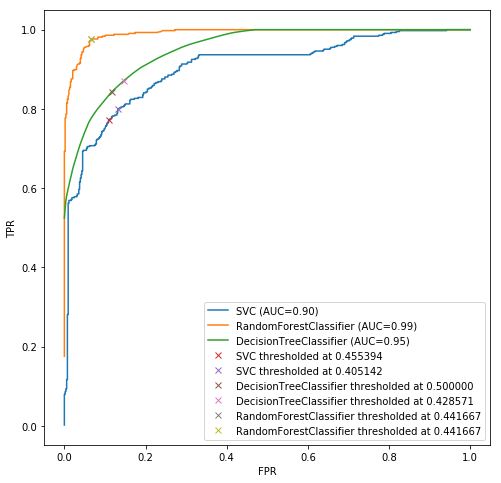

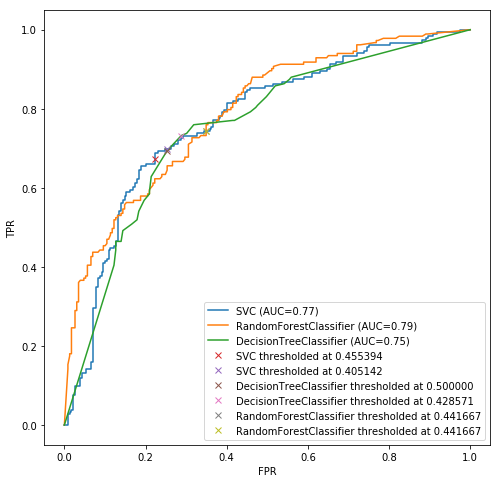

In [22]:
roc_plot([svm_tuned,rf_tuned,dt_tuned],[svm_opt_acc,svm_opt_f1,dt_opt_acc,dt_opt_f1,rf_opt_acc,rf_opt_f1],X_train,y_train)
roc_plot([svm_tuned,rf_tuned,dt_tuned],[svm_opt_acc,svm_opt_f1,dt_opt_acc,dt_opt_f1,rf_opt_acc,rf_opt_f1],X_test,y_test)

**<font color='purple'>Answer to (p):</font>** We can see that the tuned RF classifier seems to be better almost everywhere. On the test data the SVC does do a little bit better than the RFC in some places, but otherwise it is worse.

## Task 2: Logistic regression (4 points)

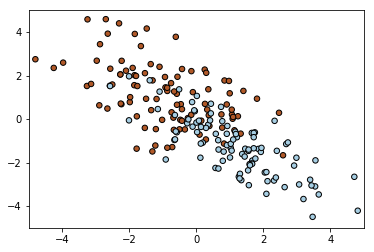

In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def create_synthetic_data(n_instances):
    n_positives = round(n_instances/2)
    n_negatives = n_instances - n_positives
    X = np.zeros((n_instances,2))
    X[:n_positives,:] = np.random.multivariate_normal((-1,+1),((2,-1),(-1,2)),n_positives)
    X[n_positives:,:] = np.random.multivariate_normal((+1,-1),((2,-1.5),(-1.5,2)),n_negatives)
    Y = n_positives*[1]+n_negatives*[0]
    return(X,Y)

np.random.seed(0)
train_X, train_Y = create_synthetic_data(200)
test_X, test_Y = create_synthetic_data(20000)

plt.scatter(train_X[:, 0], train_X[:, 1], s=30, c=train_Y, cmap=plt.cm.Paired, edgecolors='k')
plt.axis([-5, 5, -5, 5])
plt.show()

- **(a)** Implement logistic regression using gradient descent of cross entropy. For this look up the formula for cross entropy and its gradient formulas from the lecture slides. Print out the final weights and bias term. Print out the number of iterations that the algorithm ran.  

**<font color='red'>(a) Your implementation, prints out the final weights and bias term and the number of iterations:</font>**

In [25]:
bias = 0
weights = np.ones_like(train_X[0])
n = 50

it = []
test_ce = []
train_ce = []

for i in range(n):
    it.append(i)
    pt = 1 / (1 + np.exp(-1 * (np.dot(test_X, weights) + bias)))
    test_ce.append(np.subtract(np.negative(test_Y) * np.log(pt), (np.subtract(1,test_Y) * np.log(1 - pt))).mean())
    train_ce.append(np.subtract(np.negative(train_Y) * np.log(p), (np.subtract(1,train_Y) * np.log(1 - p))).mean())
    
    p = 1 / (1 + np.exp(-1 * (np.dot(train_X, weights) + bias)))
    bias -= 0.01 * np.sum(p - train_Y)
    weights[0] -= 0.01 * np.sum(np.dot(train_X[:,0], p - train_Y))
    weights[1] -= 0.01 * np.sum(np.dot(train_X[:,1], p - train_Y))

print("Final weights are: ", weights)
print("Final bias term is: ", bias)
print("Number of iterations: ", i+1)


Final weights are:  [-0.44150353  1.03315096]
Final bias term is:  0.17507625439571486
Number of iterations:  50


- **(b)** Supplement each iteration of your above implementation with the calculation of cross entropy on the training data and on the test data. Make a plot with iteration number on the x-axis and cross entropy on the y-axis, with training and test loss shown in different colour. Discuss if you see signs of overfitting.

**<font color='red'>(b) Your implementation making the plot:</font>**

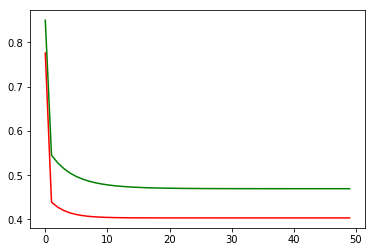

In [26]:
plt.figure()

plt.plot(it, test_ce, "g-")
plt.plot(it, train_ce, "r-")

**<font color='red'>Discuss if you see signs of overfitting:</font>** We can see a little bit of overfitting, the training dataset has a CE of roughly $0.4$, but the test dataset has a CE of $0.5$.

- **(c)** Compare your learned weights and bias term to those obtained from sklearn implementation of logistic regression. Please use the parameter C value `C=1e10` (this is needed as by default sklearn logistic regression uses regularisation). Print out the final weights and bias term. Print out the differences from what your implementation found (subtract sklearn weights and bias from your weights and bias, respectively, and print out). The coefficients from sklearn implementation and your implementation must not differ by more than 0.001 (if they do then please check your code and possibly run more iterations or adjust the learning rate). 

**<font color='red'>(c) Your code to print the model learned with sklearn implementation of logistic regression and its difference from yours:</font>**

In [27]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = 1e10)
lr.fit(train_X, train_Y)

print("The difference between the weights is: ", (lr.coef_ - weights))
print("The difference between the intercept is: ", (lr.intercept_ - bias))

The difference between the weights is:  [[-3.01349688e-05 -6.69868128e-05]]
The difference between the intercept is:  [-6.20802734e-05]


- **(d)** Implement logistic regression using **stochastic** gradient descent of cross entropy. Print out the final weights and bias term. Print out the differences in weights and bias between this implementation and sklearn. The coefficients from sklearn implementation and your implementation must not differ by more than 0.001 (if they do then please check your code and possibly run more iterations or adjust the learning rate). 

**<font color='red'>(d) Your implementation, prints out the final weights and bias term and the number of iterations, prints out the differences between your implementation and sklearn:</font>**

In [63]:
bias = 0
weights = np.ones_like(train_X[0])
n = 50

it = []
test_ce = []
train_ce = []

for i in range(n):
    for j in range(train_X.shape[0]):        
        it.append(i)
        pm = 1 / (1 + np.exp(-1 * (np.dot(train_X, weights) + bias)))
        pt = 1 / (1 + np.exp(-1 * (np.dot(test_X, weights) + bias)))
        test_ce.append(np.subtract(np.negative(test_Y) * np.log(pt), (np.subtract(1,test_Y) * np.log(1 - pt))).mean())
        train_ce.append(np.subtract(np.negative(train_Y) * np.log(pm), (np.subtract(1,train_Y) * np.log(1 - pm))).mean())
        
        p = 1 / (1 + np.exp(-1 * (np.dot(train_X[j], weights) + bias)))

        bias -= 0.01 * (p - train_Y[j])
        weights[0] -= 0.01 * (np.dot(train_X[j,0], p - train_Y[j]))
        weights[1] -= 0.01 * (np.dot(train_X[j,1], p - train_Y[j]))

print("Final weights are: ", weights)
print("Final bias term is: ", bias)
print("Number of iterations: ", i+1)

#from sklearn.linear_model import SGDClassifier
#sgd = SGDClassifier().fit(train_X, train_Y)

print("The difference between the weights is: ", (lr.coef_ - weights))
print("The difference between the intercept is: ", (lr.intercept_ - bias))

Final weights are:  [-0.45095657  1.04172734]
Final bias term is:  0.04397860090502833
Number of iterations:  50
The difference between the weights is:  [[ 0.00942291 -0.00864337]]
The difference between the intercept is:  [0.13103557]


- **(e)** About your stochastic gradient descent implementation make the same plot as you did in subtask **(b)** about gradient descent (cross entropy on train and test at each iteration). Discuss if you see signs of overfitting. Discuss the differences of plots about gradient descent and stochastic gradient descent.

**<font color='red'>Your implementation making the plot:</font>**

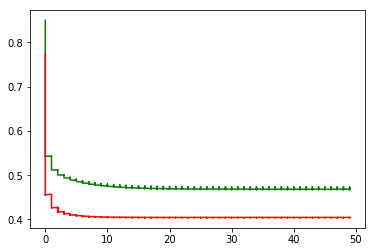

In [64]:
plt.figure()

plt.plot(it, test_ce, "g-")
plt.plot(it, train_ce, "r-")

plt.show()

**<font color='red'>Discuss if you see signs of overfitting:</font>** As it was with the gradient descent we can see that there is small signs of overfitting, since the training CE levels out at $0.4$ and the test CE levels out at $0.5$. But I don't believe it to be significant enough.

**<font color='red'>Discuss the differences of plots about gradient descent and stochastic gradient descent:</font>** Gradient descent updates the weights each iteration. Stochastic gradient descent updates the weights after each batch (currently it is after each point).

- **(f)** Calculate and report accuracy of the logistic regression model on the test data. Do this on the model learned with sklearn in subtask **(c)**. 

**<font color='red'>(f) Your implementation reporting accuracy:</font>**

In [81]:
def accuracy_calc(predictions):
    matrix = confusion_matrix(test_Y, predictions)
    acc = (matrix[0,0] + matrix[1,1])/test_X.shape[0]
    print("The accuracy of the model is: ", acc)
    
accuracy_calc(lr.predict(test_X))

The accuracy of the model is:  0.7776


- **(g)** Since we have generated the data ourselves with balanced classes drawn from two Gaussian distributions, we know what the optimal classifier is. The optimal classifier must predict positive whenever the likelihood of the positive class is higher than the likelihood of the negative class (as the class priors are equal, comparing the likelihoods is sufficient). For each test instance calculate these likelihoods and then calculate the accuracy of the optimal classifier on the test data (this classifier is known as the Bayes-optimal classifier). 

**<font color='red'>(g) Add to the following implementation and print accuracy of the Bayes-optimal classifier:</font>**

In [82]:
from scipy.stats import multivariate_normal
pos_likelihood_func = multivariate_normal(mean=(-1,+1), cov=((2,-1),(-1,2))).pdf
neg_likelihood_func = multivariate_normal(mean=(+1,-1), cov=((2,-1.5),(-1.5,2))).pdf

# Example usage:
# print(pos_likelihood_func(test_X))
# print(neg_likelihood_func(test_X))

# add your code here
posl = pos_likelihood_func(test_X)
negl = neg_likelihood_func(test_X)
pred = (posl > negl).astype(int)

accuracy_calc(pred)

The accuracy of the model is:  0.7926


- **(h)** Learn a SVM model with RBF kernel with default parameters and report the accuracy on the test data.

**<font color='red'>(h) Your implementation reporting test accuracy of SVM:</font>**

In [84]:
from sklearn import svm
svm_model = svm.SVC()

# add your code here

svmm = svm_model.fit(train_X, train_Y)
preds = svmm.predict(test_X)
accuracy_calc(preds)

The accuracy of the model is:  0.77905


- **(i)** Draw the decision boundaries of the logistic regression model learned in **(c)**, SVM model learned in **(h)** and the Bayes-optimal model (explained in **(g)**). Discuss whether logistic regression or SVM learned a better model and explain why.

**<font color='red'>Fill the gaps in the following code:</font>**

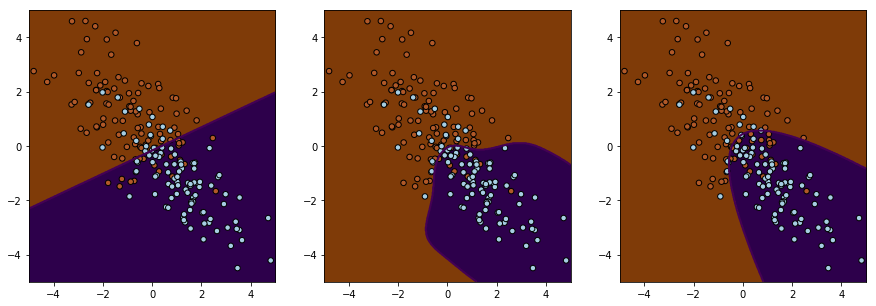

In [85]:
def make_plots(lr_model,svm_model):
    x1, x2 = np.meshgrid(np.linspace(-5, 5, 500),np.linspace(-5, 5, 500))   
    xx = np.c_[x1.ravel(), x2.ravel()]
    opt_pred = np.sign(pos_likelihood_func(xx)/(pos_likelihood_func(xx)+neg_likelihood_func(xx))-0.5)
    opt_pred = opt_pred.reshape(x1.shape)

    lr_pred = np.sign(lr_model.predict(xx)-0.5).reshape(x1.shape)
    svm_pred = np.sign(svm_model.predict(xx)-0.5).reshape(x1.shape)
    
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for i in range(3):
        pred = [lr_pred,svm_pred,opt_pred][i]
        ax = axes[i]
        ax.imshow(pred, interpolation='nearest',
                  extent=(x1.min(), x1.max(), x2.min(), x2.max()), aspect='auto',
                  origin='lower', cmap=plt.cm.PuOr_r)
        contours = ax.contour(x1, x2, pred, levels=[0], linewidths=2)
        ax.scatter(train_X[:, 0], train_X[:, 1], s=30, c=train_Y, cmap=plt.cm.Paired,
                    edgecolors='k')
        ax.axis([-5, 5, -5, 5])
    plt.show()
    
lr_model = lr
svm_model = svmm
make_plots(lr_model,svm_model)

**<font color='red'>Discuss whether logistic regression or SVM learned a better model and explain why:</font>** I would say that the logistic regression did a worse job. It basically just split the data into two parts down the middle. The SVM tried to isolate more of the negative points in one corner. We can also say that it is better since the optimal model looks more like the SVM model than the Logistic Regression model.

- **(j)** Use the logistic regression model from subtask **(c)** to obtain class probability estimates on the test data (note that you can easily do **(c)** even if you did not solve **(a)** and **(b)**). Evaluate these probabilities with cross entropy with respect to the actual class. For this implement a function calculating cross entropy. Report the value of cross entropy.

**<font color='red'>Fill the gaps in the following code and report cross entropy:</font>**

In [90]:
lr_model = lr# put the logistic regression model here
class_prob_estimates = lr_model.predict_proba(test_X)
print(class_prob_estimates[:10,:])

def cross_entropy(predicted_probabilities,actual_classes):
    # please implement this function
    result = np.mean(np.negative(actual_classes) * np.log(predicted_probabilities[:,0]) - (np.subtract(1, actual_classes)) * np.log(predicted_probabilities[:,1]))
    return(result)

print(cross_entropy(class_prob_estimates,test_Y))

[[0.47460265 0.52539735]
 [0.03979971 0.96020029]
 [0.80150196 0.19849804]
 [0.04127579 0.95872421]
 [0.27337052 0.72662948]
 [0.65205802 0.34794198]
 [0.27018086 0.72981914]
 [0.00627244 0.99372756]
 [0.08480552 0.91519448]
 [0.00597562 0.99402438]]
1.9452025502630008


- **(k)** Apply Platt scaling (also called logistic calibration) on the SVM model from **(h)**. Evaluate the resulting probabilities with cross entropy and report the result.

**<font color='red'>Fill the gaps in the following code and report cross entropy:</font>**

In [91]:
from sklearn.calibration import CalibratedClassifierCV

svm_cal = CalibratedClassifierCV(svm_model, cv=2, method='sigmoid')
svm_cal.fit(train_X, train_Y)
svm_cal_prob = svm_cal.predict_proba(test_X)

# calculate and print cross entropy on the predicted probabilities
print(cross_entropy(svm_cal_prob, test_Y))

1.4081570324254375


- **(l)** Draw the 0.25-, 0.5- and 0.75-probability lines (also called iso-lines) of the logistic regression model, calibrated SVM model and the Bayes-optimal model. Discuss whether better class probability estimates were obtained from logistic regression or from SVM after calibrating with Platt scaling. Explain why.

**<font color='red'>Fill the gaps in the following code:</font>**

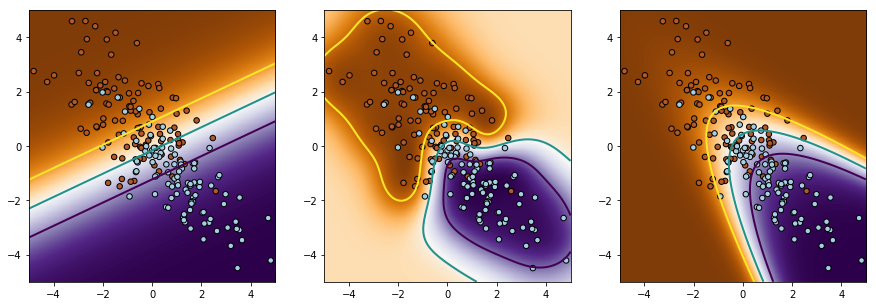

In [92]:
def make_prob_plots(lr_model,svm_cal_model):
    x1, x2 = np.meshgrid(np.linspace(-5, 5, 500),np.linspace(-5, 5, 500))   
    xx = np.c_[x1.ravel(), x2.ravel()]
    opt_pred = pos_likelihood_func(xx)/(pos_likelihood_func(xx)+neg_likelihood_func(xx))
    opt_pred = opt_pred.reshape(x1.shape)

    lr_pred = lr_model.predict_proba(xx)[:,1].reshape(x1.shape)
    svm_cal_pred = svm_cal_model.predict_proba(xx)[:,1].reshape(x1.shape)
    
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for i in range(3):
        pred = [lr_pred,svm_cal_pred,opt_pred][i]
        ax = axes[i]
        ax.imshow(pred, interpolation='nearest',
                  extent=(x1.min(), x1.max(), x2.min(), x2.max()), aspect='auto',
                  origin='lower', cmap=plt.cm.PuOr_r)
        contours = ax.contour(x1, x2, pred, levels=[0.25,0.5,0.75], linewidths=2)
        ax.scatter(train_X[:, 0], train_X[:, 1], s=30, c=train_Y, cmap=plt.cm.Paired,
                    edgecolors='k')
        ax.axis([-5, 5, -5, 5])
    plt.show()
    
lr_model = lr # put the logistic regression model here
svm_cal_model = svm_cal # put the calibrated SVM model here (Platt scaling applied on the SVM model)
make_prob_plots(lr_model,svm_cal_model)

**<font color='red'>Discuss whether better class probability estimates were obtained from logistic regression or from SVM after calibrating with Platt scaling. Explain why:</font>**
I would still say that the SVM looks more reliable. Again we can say that since it looks more like the optimal model. Also it doesn't just split the data into two parts. Instead it concentrates more on classifying the negatives more correctly and through that it predicts the positives better as well.

 ## How long did it take you to solve the homework?

Please answer as precisely as you can. It does not affect your points or grade in any way. It is okey, if it took 30 minutes or 24 hours. The results are used to improve the homeworks next year.

**<font color='red'>Task 1:</font>** 1 hour

**<font color='red'>Task 2:</font>** 2 hours

**<font color='red'>In total:</font>** 3 hours

<font color='red'>Please use <b>"Kernel->Restart and Run All"</b> command in Jupyter Notebook before submitting the homework and check your results. This ensures that we would be able to replicate your results while grading.</font>